In [ ]:
import tensorflow as tf
from keras.applications import Xception
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
import cv2
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
import os
import random


In [ ]:
model1 = load_model('mobilenet_small.h5')
model2 = load_model('xception_small.h5')

In [ ]:
models = [model1, model2]

def ensemble_predictions(members, testX):
  yhats = [model.predict(testX) for model in members]
  yhats = np.array(yhats)
  # sum across ensemble members
  summed = np.sum(yhats, axis=0)
  # argmax across classes
  result = np.argmax(summed, axis=1)
  return result

In [ ]:
test_dir = 'Train_test_val/test/Fire/'
with open("submissionEnsemble3.csv", "w") as fp:
    fp.write("Id,Category\n")

    # Image index
    i = 0
    # 1. load image and resize
    for file in os.listdir(test_dir):
        if file.endswith(".jpg"):
            # Load the image
            img = plt.imread(test_dir + file)
            # Resize it to the net input size:
            img = cv2.resize(img, (128, 128))
            img = img[np.newaxis, ...]

            # Convert the data to float:
            img = img.astype(np.float32)

            # Predict class by picking the highest probability index
            # then add 1 (due to indexing behavior)
            class_index = ensemble_predictions(models, img)[0]

            # Convert class id to name
            label = class_names[class_index]

            fp.write("%d,%s\n" %(i, label))

            print(i)
            i += 1

1/1 [==============================] - 1s 1s/step


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 1) + inhomogeneous part.

In [ ]:
import numpy as np
from tensorflow.keras.applications import Xception, ResNet50, InceptionV3
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input, Concatenate, Average
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras
from keras import Input


In [ ]:


# Define data directories and other parameters
train_data_dir = 'Train_test_val_new/train/'
validation_data_dir = 'Train_test_val_new/val/'
test_dir = 'Train_test_val_new/test/'
img_width, img_height = 128, 128  # Adjust according to the input size of models
batch_size = 32


In [ ]:

# Create data generators
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

validation_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # Set to False for validation
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

test_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # Set to False for validation
)

Found 10221 images belonging to 2 classes.
Found 1276 images belonging to 2 classes.
Found 1276 images belonging to 2 classes.


In [ ]:
tf.random.set_seed(111)
# Load pre-trained models
input_tensor = Input(shape=(img_width, img_height, 3))

# Base models
xception_base = Xception(weights='imagenet', include_top=False, input_tensor=input_tensor)
mobilenet_base = MobileNetV2(input_tensor=input_tensor, alpha=1.0, include_top=False)
# inception_base = InceptionV3(weights='imagenet', include_top=False, input_tensor=input_tensor)

# Add custom output layers for each base model
xception_out = Flatten()(xception_base.output)
xception_out = Dense(1024, activation='relu')(xception_out)
xception_out = Dense(1, activation='sigmoid')(xception_out)

mobilenet_out = Flatten()(mobilenet_base.output)
mobilenet_out = Dense(1024, activation='relu')(mobilenet_out)
mobilenet_out = Dense(1, activation='sigmoid')(mobilenet_out)

# inception_out = GlobalAveragePooling2D()(inception_base.output)
# inception_out = Dense(1024, activation='relu')(inception_out)
# inception_out = Dense(1, activation='sigmoid')(inception_out)


In [ ]:

# Create models for each base model
xception_model = Model(inputs=input_tensor, outputs=xception_out)
mobilenet_model = Model(inputs=input_tensor, outputs=mobilenet_out)
#inception_model = Model(inputs=input_tensor, outputs=inception_out)

# Combine the models into an ensemble model
ensemble_input = Input(shape=(img_width, img_height, 3))
xception_output = xception_model(ensemble_input)
mobilenet_output = mobilenet_model(ensemble_input)
#inception_output = inception_model(ensemble_input)

ensemble_outputs = Average()([xception_output, mobilenet_output])
ensemble_predictions = Dense(1, activation='sigmoid')(ensemble_outputs)

ensemble_model = Model(inputs=ensemble_input, outputs=ensemble_predictions)

# Compile the ensemble model
ensemble_model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the ensemble model
history = ensemble_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

# Now you can use ensemble_model for evaluation or further analysis


Epoch 1/15
214/319 [===================>..........] - ETA: 6:21 - loss: 0.6808 - accuracy: 0.6960

C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\PIL\Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


319/319 [==============================] - 1214s 4s/step - loss: 0.6740 - accuracy: 0.7225 - val_loss: 0.6584 - val_accuracy: 0.8189
Epoch 2/15
319/319 [==============================] - 1373s 4s/step - loss: 0.6460 - accuracy: 0.7835 - val_loss: 0.6492 - val_accuracy: 0.7564
Epoch 3/15
319/319 [==============================] - 1166s 4s/step - loss: 0.6419 - accuracy: 0.7202 - val_loss: 0.6871 - val_accuracy: 0.5641
Epoch 4/15
319/319 [==============================] - 1173s 4s/step - loss: 0.6318 - accuracy: 0.7932 - val_loss: 0.6235 - val_accuracy: 0.8109
Epoch 5/15
319/319 [==============================] - 1181s 4s/step - loss: 0.6062 - accuracy: 0.7589 - val_loss: 0.6553 - val_accuracy: 0.4663
Epoch 6/15
319/319 [==============================] - 1177s 4s/step - loss: 0.6188 - accuracy: 0.7237 - val_loss: 0.6705 - val_accuracy: 0.6058
Epoch 7/15
319/319 [==============================] - 1157s 4s/step - loss: 0.5517 - accuracy: 0.8112 - val_loss: 0.6486 - val_accuracy: 0.4663
Epo

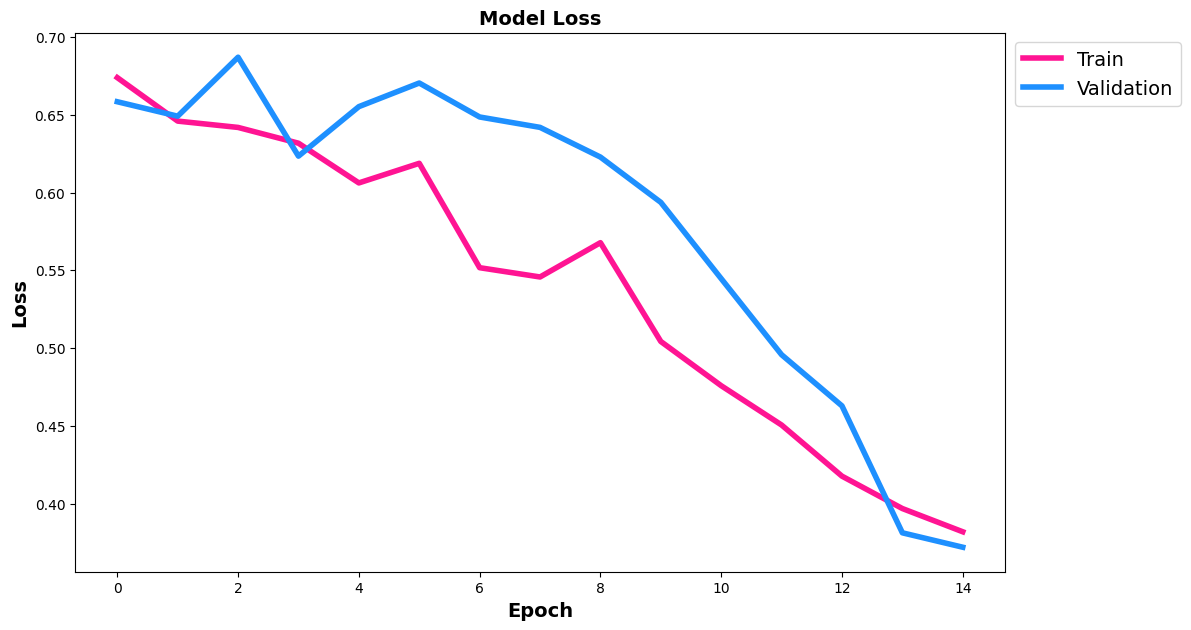

In [ ]:
plt.figure(figsize=(12,7))
plt.plot(history.history['loss'], color='deeppink', linewidth=4)
plt.plot(history.history['val_loss'], color='dodgerblue', linewidth=4)
plt.title('Model Loss', fontsize=14, fontweight='bold')
plt.ylabel('Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=14, fontweight='bold')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1), fontsize=14)
plt.show()

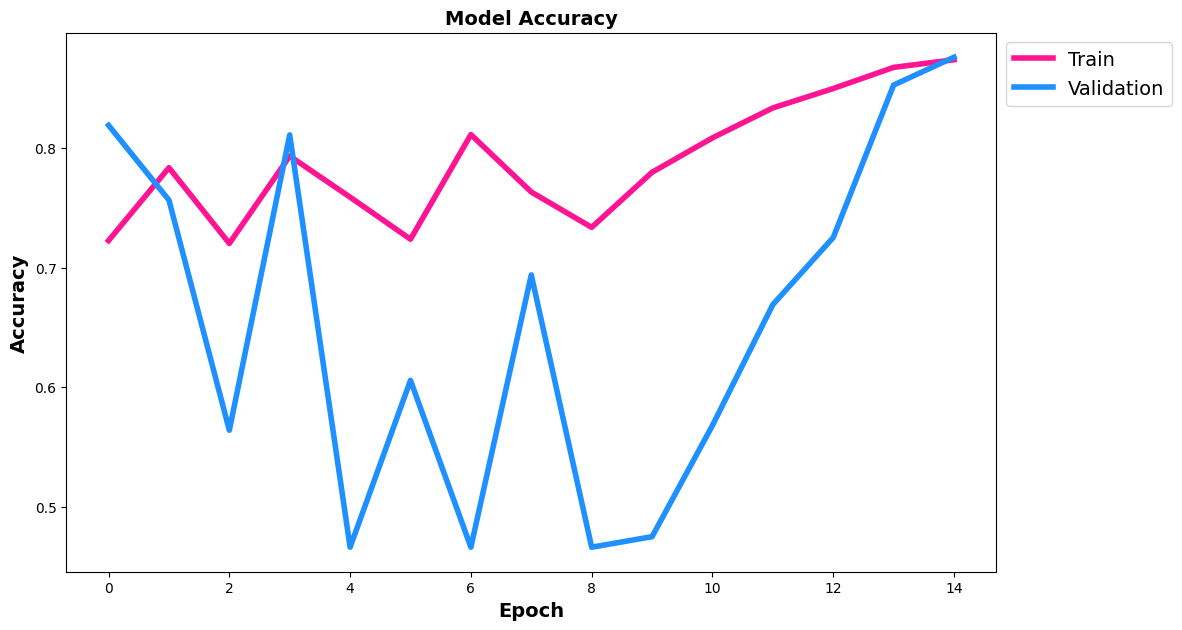

In [ ]:
plt.figure(figsize=(12,7))
plt.plot(history.history['accuracy'], color='deeppink', linewidth=4)
plt.plot(history.history['val_accuracy'], color='dodgerblue', linewidth=4)
plt.title('Model Accuracy', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=14, fontweight='bold')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1), fontsize=14)
plt.show()

40/40 [==============================] - 25s 573ms/step
Accuracy: 0.87
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.88      0.88       666
           1       0.87      0.86      0.86       610

    accuracy                           0.87      1276
   macro avg       0.87      0.87      0.87      1276
weighted avg       0.87      0.87      0.87      1276

ROC-AUC: 0.92


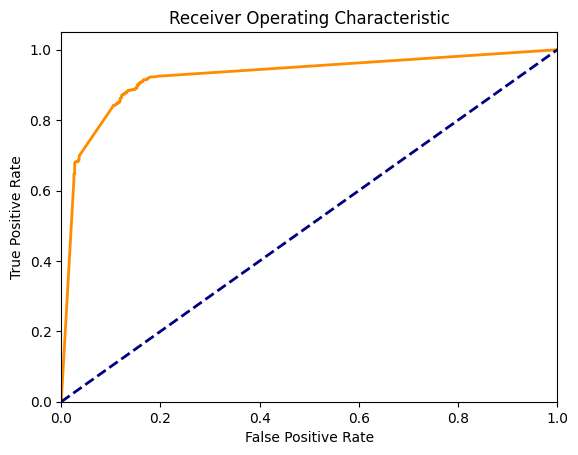

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt

# Generate predictions using the ensemble model on the validation data
validation_predictions = ensemble_model.predict(test_generator)

# Convert predictions to binary labels (0 or 1)
validation_labels = (validation_predictions > 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(test_generator.classes, validation_labels)
print(f"Accuracy: {accuracy:.2f}")

# Generate a classification report
report = classification_report(test_generator.classes, validation_labels)
print("Classification Report:\n", report)

# Calculate ROC-AUC
roc_auc = roc_auc_score(test_generator.classes, validation_predictions)
print(f"ROC-AUC: {roc_auc:.2f}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(test_generator.classes, validation_predictions)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.show()


In [ ]:
ensemble_model.save('xcep_mob_ens_new.h5')

C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
ensemble_model.save('xcep_mob_ens.h5')

C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


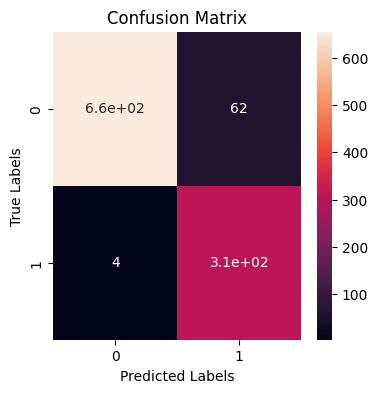

In [ ]:
import seaborn as sns

confmx = confusion_matrix(test_generator.classes, validation_labels)
f, ax = plt.subplots(figsize = (4,4))
sns.heatmap(confmx, annot=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
input_tensor = Input(shape=(img_width, img_height, 3))

# Base models
xception_base = Xception(weights='imagenet', include_top=False, input_tensor=input_tensor)
resnet_base = ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)
inception_base = InceptionV3(weights='imagenet', include_top=False, input_tensor=input_tensor)

# Add custom output layers for each base model
xception_out = GlobalAveragePooling2D()(xception_base.output)
xception_out = Dense(1024, activation='relu')(xception_out)
xception_out = Dense(1, activation='sigmoid')(xception_out)

resnet_out = GlobalAveragePooling2D()(resnet_base.output)
resnet_out = Dense(1024, activation='relu')(resnet_out)
resnet_out = Dense(1, activation='sigmoid')(resnet_out)

inception_out = GlobalAveragePooling2D()(inception_base.output)
inception_out = Dense(1024, activation='relu')(inception_out)
inception_out = Dense(1, activation='sigmoid')(inception_out)

# Create models for each base model
xception_model = Model(inputs=input_tensor, outputs=xception_out)
resnet_model = Model(inputs=input_tensor, outputs=resnet_out)
inception_model = Model(inputs=input_tensor, outputs=inception_out)

# Combine the models into an ensemble model
ensemble_input = Input(shape=(img_width, img_height, 3))
xception_output = xception_model(ensemble_input)
resnet_output = resnet_model(ensemble_input)
inception_output = inception_model(ensemble_input)

ensemble_outputs = Concatenate()([xception_output, resnet_output, inception_output])
ensemble_predictions = Dense(1, activation='sigmoid')(ensemble_outputs)

ensemble_model = Model(inputs=ensemble_input, outputs=ensemble_predictions)

# Compile the ensemble model
ensemble_model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the ensemble model
ensemble_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

87910968/87910968 [==============================] - 11s 0us/step


Epoch 1/15
192/256 [=====================>........] - ETA: 6:32 - loss: 0.4508 - accuracy: 0.8556

C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\PIL\Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


256/256 [==============================] - 1662s 6s/step - loss: 0.4426 - accuracy: 0.8616 - val_loss: 0.6536 - val_accuracy: 0.7969
Epoch 2/15
256/256 [==============================] - 1585s 6s/step - loss: 0.3818 - accuracy: 0.8840 - val_loss: 0.5036 - val_accuracy: 0.7227
Epoch 3/15
256/256 [==============================] - 1583s 6s/step - loss: 0.3488 - accuracy: 0.8888 - val_loss: 0.4249 - val_accuracy: 0.8965
Epoch 4/15
256/256 [==============================] - 3239s 13s/step - loss: 0.2946 - accuracy: 0.9090 - val_loss: 0.2663 - val_accuracy: 0.9219
Epoch 5/15
256/256 [==============================] - 1573s 6s/step - loss: 0.2754 - accuracy: 0.9166 - val_loss: 0.3177 - val_accuracy: 0.9199
Epoch 6/15
256/256 [==============================] - 1592s 6s/step - loss: 0.3092 - accuracy: 0.9127 - val_loss: 0.5894 - val_accuracy: 0.9248
Epoch 7/15
256/256 [==============================] - 1558s 6s/step - loss: 0.3066 - accuracy: 0.8705 - val_loss: 0.2507 - val_accuracy: 0.9199
Ep

In [ ]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Average

In [ ]:
model_1 = load_model('xception_small.h5')
model_1 = Model(inputs=model_1.inputs,
                outputs=model_1.outputs,
                name='xception')
model_2 = load_model('mobilenet_small.h5')
model_2 = Model(inputs=model_2.inputs,
                outputs=model_2.outputs,
                name='MobileNetV2')

In [ ]:
models = [model_1, model_2]
model_input = Input(shape=(128, 128, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = Average()(model_outputs)
ensemble_model = Model(inputs=model_input, outputs=ensemble_output, name='ensemble')
ensemble_model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
ensemble_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

Epoch 1/15
 56/256 [=====>........................] - ETA: 10:39 - loss: 0.3233 - accuracy: 0.5307

C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\PIL\Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


256/256 [==============================] - 855s 3s/step - loss: 0.3184 - accuracy: 0.5113 - val_loss: 0.3478 - val_accuracy: 0.7041
Epoch 2/15
256/256 [==============================] - 836s 3s/step - loss: 0.3217 - accuracy: 0.4717 - val_loss: 0.3169 - val_accuracy: 0.7168
Epoch 3/15
256/256 [==============================] - 821s 3s/step - loss: 0.3218 - accuracy: 0.5015 - val_loss: 0.3331 - val_accuracy: 0.6982
Epoch 4/15
256/256 [==============================] - 820s 3s/step - loss: 0.3184 - accuracy: 0.4836 - val_loss: 0.3203 - val_accuracy: 0.6436
Epoch 5/15
183/256 [====================>.........] - ETA: 3:49 - loss: 0.3187 - accuracy: 0.5170

: 